# Algorytmy Macierzowe
## Zadanie 3: Mnożenie macierzy rzadkich
## Autorzy: Jan Izydorczyk, Aleksander Wójtowicz

# Cel zadania
Celem zadania było wykonanie eksperymentu polegającego na przetestowaniu czasu mnożenia macierzy rzadkich, w zależności od ich reprezentacji. 

W zadanym problemie testowaliśmy kombinacje:
- Reprezentacja gęsta $\times$ Reprezentacja gęsta
- Reprezentacja gęsta $\times$ Reprezentacja Coordinate System 

# Wybór macierzy

Jako macierz testową wybraliśmy blokową macierz powstałą z macierzy typu rIGA, wygenerowanej za pomocą dołączonego skryptu w zestawie zadania (używjąc funkcji `massmatrix`, z parametrami `2, 4, 2, 2`). Macierz bazowa ta ma rozmiar $49 \times 49$, macierz wynikowa powstała z zwielokrotnienia tej macierzy wzdłuż każdej osi $2^5$ razy, co ostatnie daje macierz o wymiarach $49 \cdot 2^5 \times 49 \cdot 2^5 = 1568 \times 1568$.

Jest to największa macierz, jaka była testowana w pierwszym zadaniu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iface

In [2]:
def load_base_matrix():  
    with open('riga49.csv', 'r') as file:
        return iface.read_matrix(file)
    # return np.genfromtxt('riga49.csv', delimiter=',')
    
    
def generate_matrix(q):
    t = load_base_matrix()
    return np.block([[t] * q] * q)

In [3]:
q = 2**5
A = generate_matrix(q)
B = A
AxB = A@B
T = load_base_matrix()

# Wizualizacja macierzy

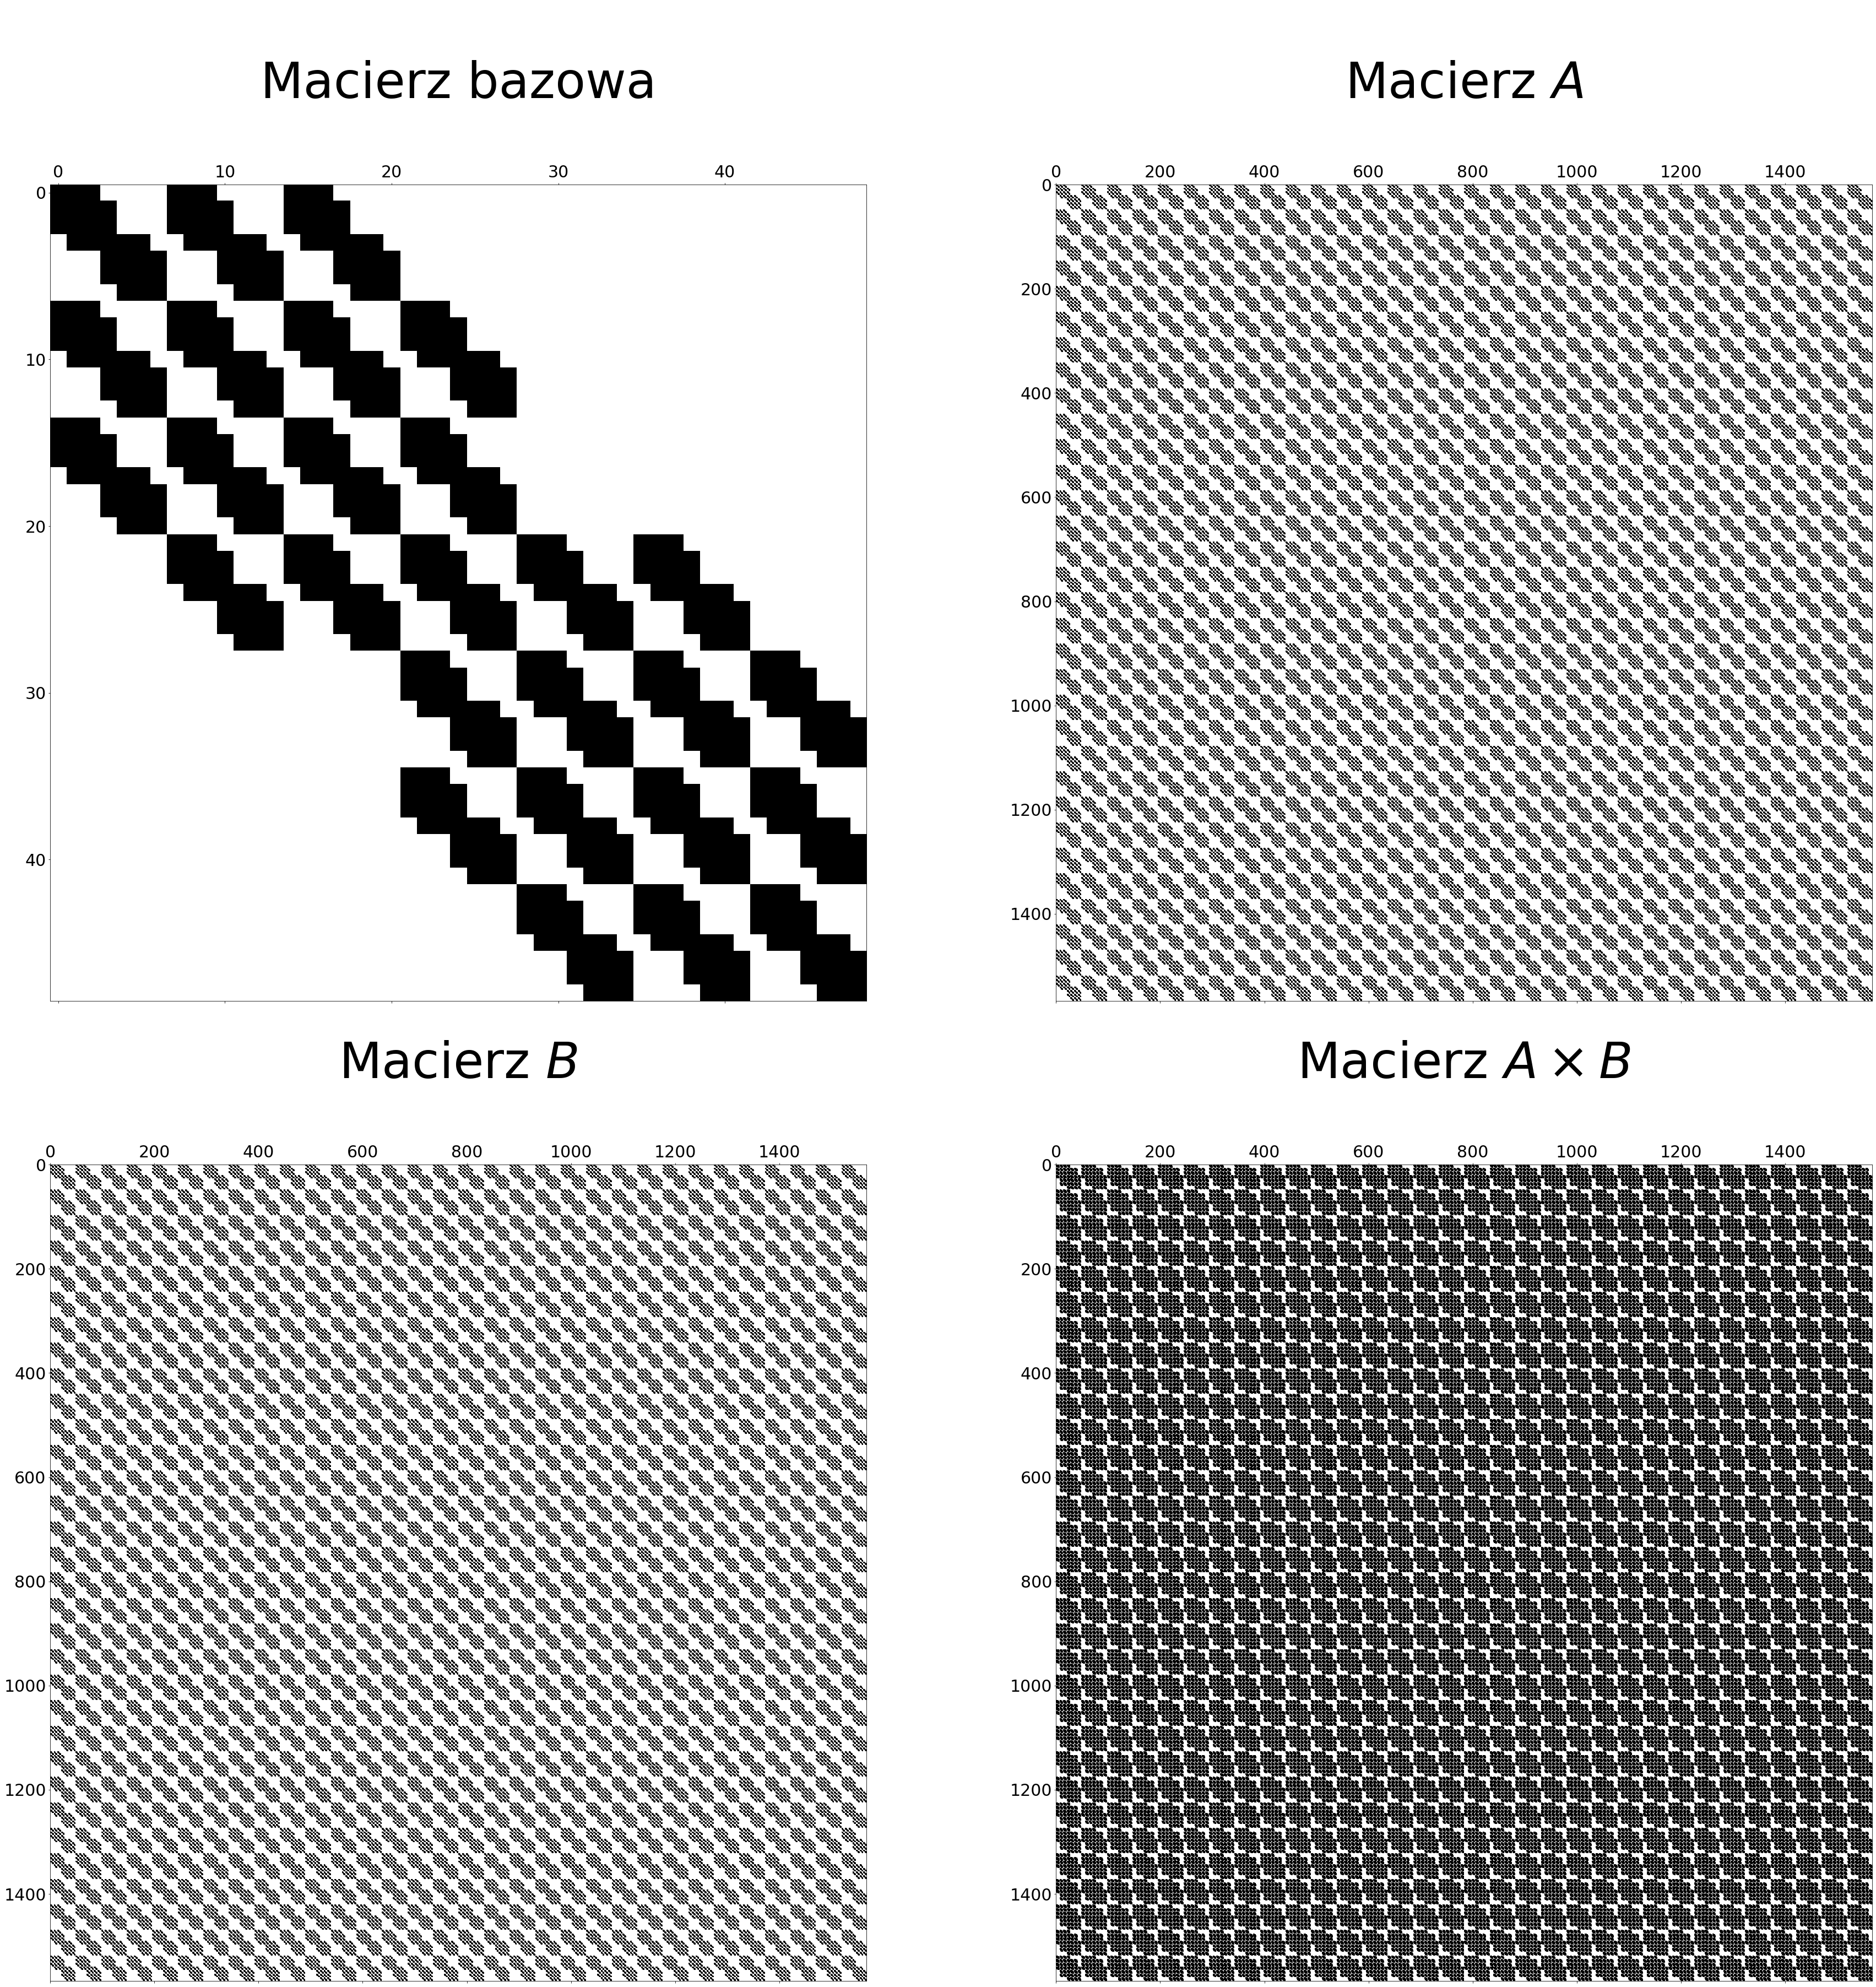

In [4]:
fig, axs = plt.subplots(2, 2, figsize = (60, 60))
axs = axs.flatten()

matrices = [T, A, B, AxB]
titles = ['Macierz bazowa', 'Macierz $A$', 'Macierz $B$', 'Macierz $A \\times B$']


for ax, matrix, title in zip(axs, matrices, titles):
    ax.spy(matrix)
    ax.set_title(f'\n{title}\n', fontsize=90)
    ax.tick_params(axis='both', labelsize=30)
    
plt.show()

# Program do mnożenia i reprezentacji macierzy

## TO DO

In [5]:
calc = iface.calc

# Testy mnożenia różnych kombinacji reprezentacji macierzy



Dla każdej wersji wykonujemy 20 testów, które są następnie uśredniane.

Dodatkowo, oprócz mierzenia tylko całkowitego czasu wykonania mnożenia, mierzyliśmy osobno czas zmiany formatu macierzy jak i czas wykonywania głównych obliczeń.

In [6]:
representations = [
    'dense',
    'coord'
] 

def measure_time(A, B, representations=representations, tries=1):
    res_df = []
    for representation in representations:
        sum_time_prep = 0
        sum_time_calc = 0
        for _ in range(tries):
            time_prep, time_calc, _ = calc(A, B, representation)
            sum_time_prep += time_prep
            sum_time_calc += time_calc
        avg_time_prep = sum_time_prep / tries
        avg_time_calc = sum_time_calc / tries
        res_df.append([representation, avg_time_prep, avg_time_calc])
        print(f'{representation}: preparation - {avg_time_prep:.2f}s, calculation - {avg_time_calc: .2f}s')
    res = pd.DataFrame(res_df, columns=('representation', 'avg_time_prep', 'avg_time_calc'))
    res['avg_time_whole'] = res['avg_time_prep'] + res['avg_time_calc'] 
    return res

In [7]:
import os
force_recalculations = False
results_filename = 'results.csv' 
if not os.path.exists(results_filename) or force_recalculations:
    res_df = res_df = measure_time(A, B, tries=20)
    res_df.to_csv(results_filename)
else:
    res_df = pd.read_csv(results_filename, index_col = 0)

In [21]:
res_map = {'representation': 'Reprezentacja', 'avg_time_prep': 'Średni czas zmiany formatu [s]', 'avg_time_calc': 'Średni czas mnożenia [s]', 'avg_time_whole': 'Średni łączny czas [s]'}
rep_map = {'dense': 'Reprezentacja Gęsta', 'coord': 'Reprezentacja Coordindate Format'}
res_df.replace({'representation': rep_map}).rename(columns=res_map)

,Reprezentacja,Średni czas zmiany formatu [s],Średni czas mnożenia [s],Średni łączny czas [s]
0,Reprezentacja Gęsta,0.0000,1.03125,1.03125
1,Reprezentacja Coordindate Format,0.0067,0.26535,0.27205


In [9]:
matrix_size = '$49 \\cdot 2^{5} \\times 49 \\cdot 2^{5}$'

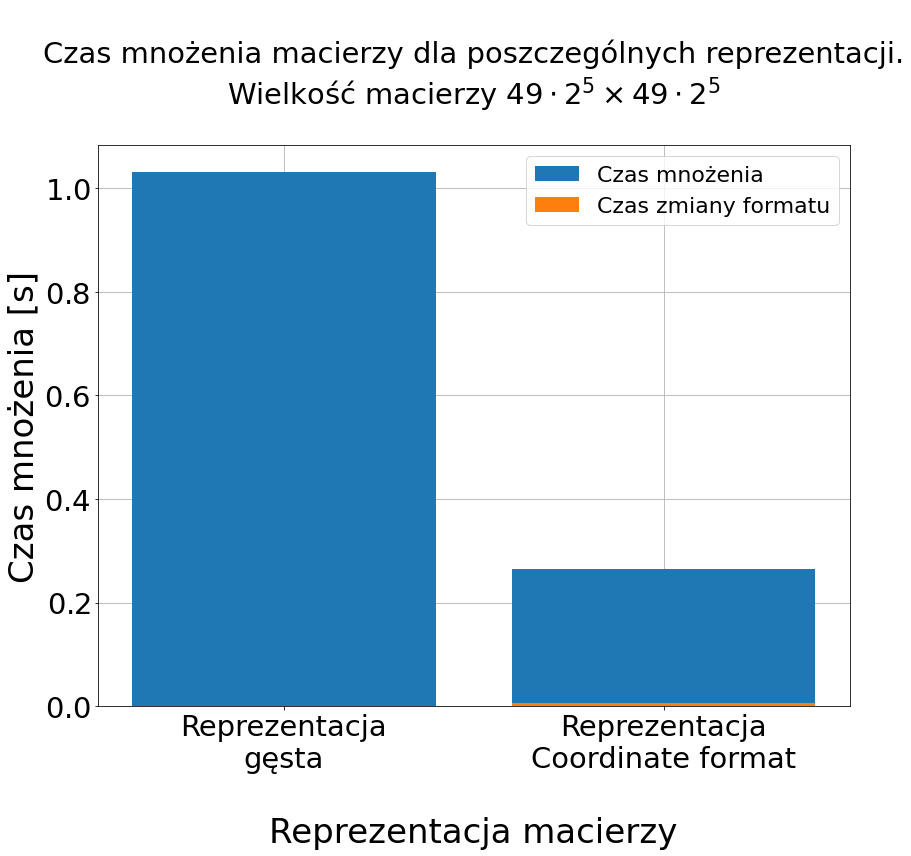

In [16]:
rep_map = {
    'dense': 'Reprezentacja\ngęsta',
    'coord': 'Reprezentacja\nCoordinate format'
}
fig = plt.figure(figsize = (12, 12))
plt.title(f'\nCzas mnożenia macierzy dla poszczególnych reprezentacji.\nWielkość macierzy {matrix_size}\n', fontsize = 29)
plt.xlabel('\nReprezentacja macierzy', fontsize = 34)
plt.ylabel('Czas mnożenia [s]', fontsize = 34)
plt.tick_params(axis='both', which='major', labelsize = 29)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
# plt.yscale('log')
plt.grid(zorder=-1)

xs, ys_calc, ys_prep = res_df['representation'].map(rep_map), res_df['avg_time_calc'], res_df['avg_time_prep']
p_calc = plt.bar(xs, ys_calc, zorder=3)
p_prep =  plt.bar(xs, ys_prep, zorder=3)

plt.legend((p_calc[0], p_prep[0]), ('Czas mnożenia', 'Czas zmiany formatu'), fontsize=22)

fig.tight_layout()
plt.show()

# Wnioski

Dla wybranej macierzy rzadkiej reprezentacja w formacie Coordinate Format pozwoliła uzyskać czterokrotne przyspieszenie obliczeń, uwzględniając łaczny czas wykonywnia obliczeń podczas mnożenia, jak i czas konwersji macierzy z formatu gęstego na Coordinate Format.